## TV-Minimized Reconstruction

Now that we've done denoising - let's look at reconstructing a signal from samples of its Fourier Transform

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [2]:
def tv_objective(b, lam, x, z):
    return 0.5 * np.linalg.norm(x - b)**2 + lam * np.linalg.norm(z)

def shrinkage(a, kappa):
    return np.clip(a-kappa, a_min=0, a_max=None) - np.clip(-a-kappa, a_min=0, a_max=None)

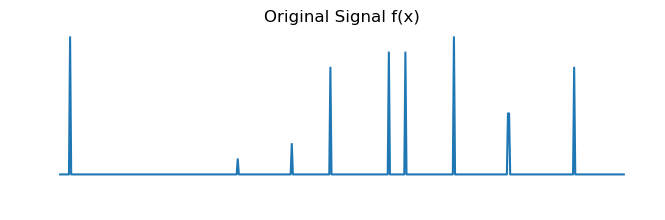

In [10]:
# generate some data
n = 512
noise_level = 0.05

cycles = 2
chunks = 5

b = np.sin(np.linspace(0, np.pi * 2 * cycles, n))
if chunks > 0:
    for i in range(0, n - n//(2*chunks), n//chunks):
        b[range(i, i + n//(2*chunks))] *= 0

b_ = noise_level * np.random.randn(n) + b

# random spikes
b = np.zeros((n,))
b[np.random.permutation(n)[:10]] = np.random.randint(1, 10, 10)

fig, ax = plt.subplots(figsize=(8, 2))
# ax.plot(b_, label='5% noise')
ax.plot(b, label='no noise')
# ax.legend(loc='upper right', prop={'size': 10})
ax.axis('off')
ax.set_title('Original Signal f(x)', size=12)

fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/signal_1d.png", bbox_inches='tight', transparent=True)

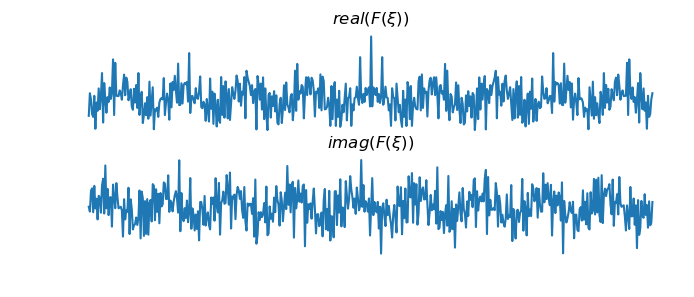

In [11]:
B = np.fft.fftshift(np.fft.fft(b))
fig, axs = plt.subplots(2, 1, figsize=(8, 3))
axs[0].plot(np.real(B), label='no noise')
axs[1].plot(np.imag(B), label='no noise')
# ax.legend(loc='upper right', prop={'size': 10})
axs[0].axis('off')
_ = axs[1].axis('off')
axs[0].set_title('$real(F(\\xi))$', size=12)
axs[1].set_title('$imag(F(\\xi))$', size=12)
fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/signal_FT_1d.png", bbox_inches='tight', transparent=True)

Actual Acceleration: 2.81318681319


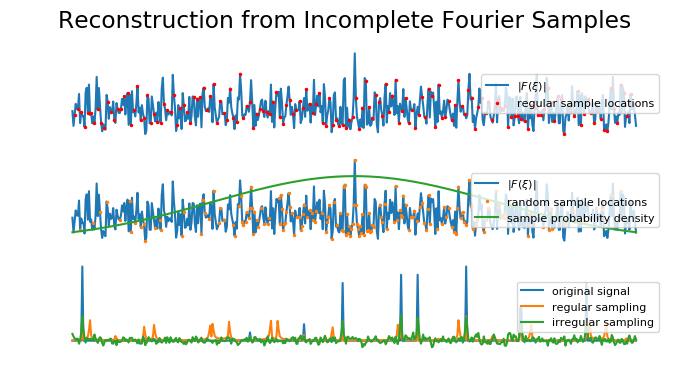

In [12]:
random_sampling_mask = np.zeros(B.shape, dtype=np.int)
R = 3

C = 5 # percent fully-sampled central region

# random sampling
# samples = np.random.permutation(n)[0:int(n/R)]
# center_samples = np.arange(n//2 - int(n*C/2/100), n//2 + int(n*C/2/100))

# gaussian-random sampling mask
gaussian_pdf = np.exp(-0.5 * np.linspace(-2, 2, n)**2) / np.sqrt(2*np.pi)
gaussian_pdf /= np.sum(gaussian_pdf)
samples = np.random.choice(np.arange(n), size=n//R, replace=False, p=gaussian_pdf)

# ensure a fully-sampled central region
center_samples = np.arange(n//2 - int(n*C/2/100), n//2 + int(n*C/2/100))
samples = np.unique(np.hstack((samples, center_samples)))
random_sampling_mask[samples] = 1
random_sampling_mask = random_sampling_mask > 0
print("Actual Acceleration:", n/sum(random_sampling_mask))

sampling_mask = np.ones(B.shape)
sampling_mask[::3] = 0
sampling_mask[1::3] = 0
regular_samples = np.argwhere(sampling_mask > 0)

b_aliased_irregular = np.fft.ifft(np.fft.fftshift(B*random_sampling_mask), n)
b_aliased_regular = np.fft.ifft(np.fft.fftshift(B*sampling_mask), n)
B_subsampled = B[random_sampling_mask]

fig, axs = plt.subplots(3, 1, figsize=(8, 4))
axs[0].plot(np.abs(B), label='$|F(\\xi)|$')
axs[0].plot(regular_samples, np.abs(B*sampling_mask)[regular_samples], 'r.', label='regular sample locations', markersize=3)
axs[0].axis('off')
axs[0].legend(loc='right', prop={'size': 8})

axs[1].plot(np.abs(B), label='$|F(\\xi)|$')
axs[1].plot(samples, np.abs(B*random_sampling_mask)[samples], '.', label='random sample locations', markersize=3)
axs[1].plot(gaussian_pdf / np.max(gaussian_pdf) * np.max(np.abs(B) * 0.8), label='sample probability density')
axs[1].axis('off')
axs[1].legend(loc='right', prop={'size': 8})

# fig, ax = plt.subplots(figsize=(8, 2))
axs[2].plot(b, label='original signal')
axs[2].plot(np.abs(b_aliased_regular), label='regular sampling')
axs[2].plot(np.real(b_aliased_irregular), label='irregular sampling')
axs[2].axis('off')
axs[2].legend(loc='right', prop={'size': 8})

fig.suptitle("Reconstruction from Incomplete Fourier Samples") # , size=14)

fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/zero_filling_recon_comparison_1d.png", bbox_inches='tight', transparent=True)

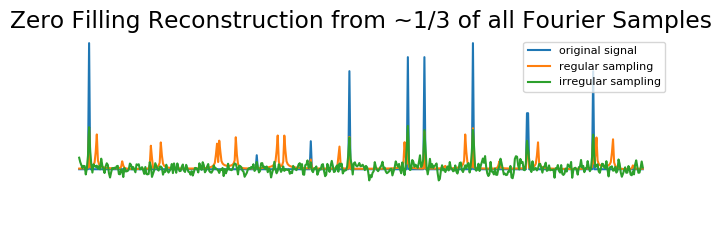

In [13]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.set_title("Zero Filling Reconstruction from ~1/3 of all Fourier Samples") #, size=14)
ax.plot(b, label='original signal')
ax.plot(np.abs(b_aliased_regular), label='regular sampling')
ax.plot(np.real(b_aliased_irregular), label='irregular sampling')
ax.axis('off')
# ax.legend(loc='center left', prop={'size': 10}, bbox_to_anchor=(0.9, 0.5))
ax.legend(loc='best', prop={'size': 8})

# fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/zero_filling_recon_comparison_1d.png", bbox_inches='tight', transparent=True)

In [14]:
from scipy.sparse.linalg import LinearOperator, cg, bicgstab

def tv_recon(b, mask, lam, rho, alpha):
    """ Solve total variation minimization via ADMM *without forming the difference matrices*

    Solves the following problem via ADMM:

       min  (1/2)||Ax - b||_2^2 + lambda * sum_i |x_{i+1} - x_i|
       
       where b is the measured signal (undersampled FT samples)
       x is the reconstructed signal
       A is both FT and undersampling (BU - see Afonso 2009 section III-C-4)
       
    """
    
    MAX_ITER = 20000
    ABSTOL = 1e-4
    RELTOL = 1e-2

    n = len(mask)
        
    if mask.dtype != bool:
        mask = mask > 0

    # sampling and reconstruction operators
    # FFT and undersample
    def U(v):
        return np.fft.fftshift(np.fft.fft(v))[mask]

    # zero-fill and IFFT
    def U_H(v):
        v_ = np.zeros(mask.shape, v.dtype)
        v_[mask] = v
        return np.fft.ifft(np.fft.fftshift(v_))

    # difference matrix operator
    def D(v):
        return v - np.roll(v, -1)

    def D_H(v):
        return v - np.roll(v, 1)

    def F_matvec(v):
        return U_H(U(v)) + rho * D_H(D(v))

    F = LinearOperator((n,n), matvec=F_matvec, rmatvec=F_matvec)
    
    def tv_recon_objective(b, lam, x, z):
        return 0.5 * np.linalg.norm(U(x) - b)**2 + lam * np.linalg.norm(z)
    
    def Finv(v):
        # return 1/rho * v - rho/(1+rho) * U_H(U(v))
        return v - rho * D_H()

    x = np.zeros((n,), dtype=b.dtype)
    z = x.copy()
    u = x.copy()

    history = {'objval' : [None]*MAX_ITER,
               'r_norm': [None]*MAX_ITER,
               's_norm': [None]*MAX_ITER,
               'eps_prim': [None]*MAX_ITER,
               'eps_dual': [None]*MAX_ITER}

    for k in range(MAX_ITER):

        # x-update (minimization) for data consistency
        # iterative version
        x, _ = cg(F, U_H(b) + rho * D_H(z - u), maxiter=min(1, k//100), x0 = x)
        # direct version
        # x = Finv(U_H(b) + rho * D_H(z - u))
        
        # z-update (minimization) with relaxation
        # uses soft thresholding - the proximity operator of the l-1 norm
        z_ = z
        Fx_hat = alpha * D(x) + (1 - alpha) * z_
        z = shrinkage(Fx_hat + u, lam / rho)

        # y-update (dual update)
        u = u + Fx_hat - z

        # keep track of progress
        objval = tv_recon_objective(b, lam, x, z)

        r_norm = np.linalg.norm(D(x) - z)
        s_norm = np.linalg.norm(-rho * D_H(z - z_))

        eps_prim = np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(D(x)),
                                                      np.linalg.norm(-z))
        eps_dual = np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(rho * D_H(u))

        history['objval'][k] = objval
        history['r_norm'][k] = r_norm
        history['s_norm'][k] = s_norm
        history['eps_prim'][k] = eps_prim
        history['eps_dual'][k] = eps_dual

        if r_norm < eps_prim and s_norm < eps_dual:
            break

    return history, x

CPU times: user 9.15 ms, sys: 273 µs, total: 9.43 ms
Wall time: 9.44 ms
CPU times: user 27.5 ms, sys: 642 µs, total: 28.2 ms
Wall time: 28.5 ms
CPU times: user 14.5 s, sys: 154 ms, total: 14.7 s
Wall time: 14.7 s
CPU times: user 2.64 s, sys: 28.8 ms, total: 2.67 s
Wall time: 2.67 s
CPU times: user 647 ms, sys: 7.92 ms, total: 655 ms
Wall time: 655 ms
CPU times: user 349 ms, sys: 5.03 ms, total: 354 ms
Wall time: 354 ms
CPU times: user 14.3 s, sys: 142 ms, total: 14.5 s
Wall time: 14.5 s


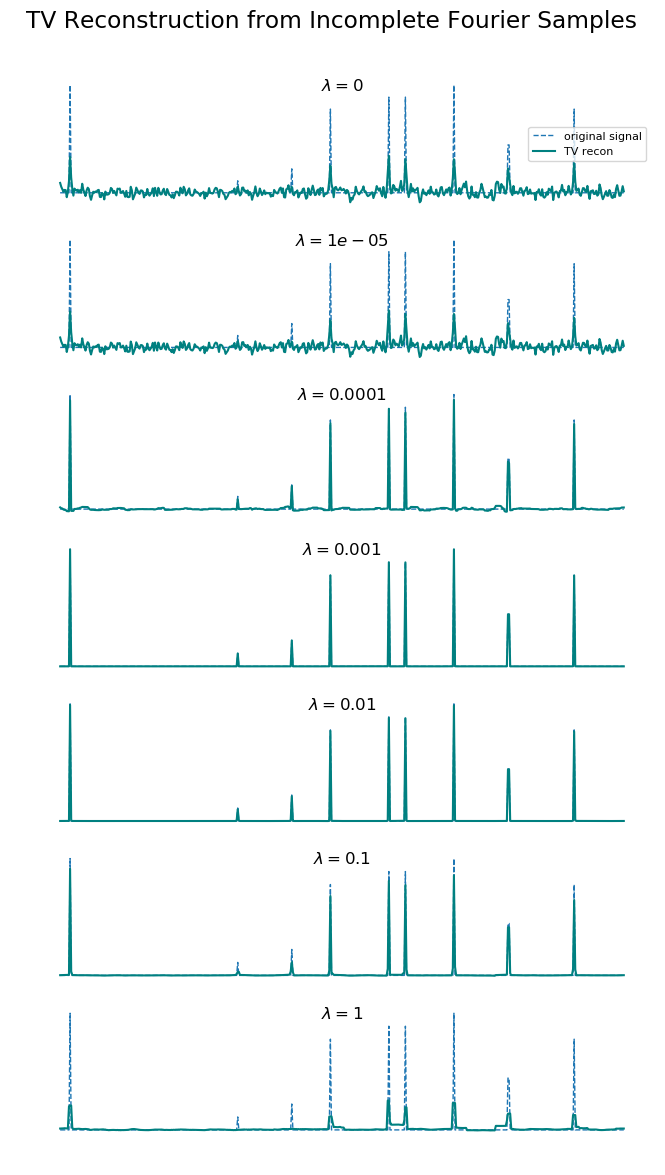

In [15]:
lambdas = [0] + [10 ** l for l in range(-5, 1)]

fig, axs = plt.subplots(len(lambdas), 1, figsize=(8, len(lambdas)*2))
fig.suptitle("TV Reconstruction from Incomplete Fourier Samples", y=0.93)

for i, lam in enumerate(lambdas):
    %time hist, x = tv_recon(B_subsampled, random_sampling_mask, lam, 0.1, 1.5)
    axs[i].plot(b, '--', label='original signal', linewidth=1)
    axs[i].plot(np.real(x), 'teal', label=f'TV recon')
    # axs[i].plot(np.real(z_u), 'black', label=f'D_H(z-u)')
    axs[i].set_title(f'$\lambda = {lam}$', size=12, y=0.85)
    axs[i].axis('off')
    
axs[0].legend(loc='right', prop={'size': 8}) # loc='center left', prop={'size': 10}, bbox_to_anchor=(0.9, 0.5))
    
fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/TV_recon_1d.png", bbox_inches='tight', transparent=True)

In [37]:
from scipy.sparse.linalg import LinearOperator, cg

def tv_recon_2d(b, mask, lam=1.0, rho=1.0, alpha=1.0):
    """ Solve total variation minimization via ADMM *without forming the difference matrices*

    Solves the following problem via ADMM:

       min  (1/2)||Ax - b||_2^2 + lambda * sum_i |x_{i+1} - x_i|
       
       where b is the measured signal (undersampled FT samples)
       x is the reconstructed signal
       A is both FT and undersampling (BU - see Afonso 2009 section III-C-4)
       
    """
    
    MAX_ITER = 2000
    ABSTOL = 1e-4
    RELTOL = 1e-2

    n = b.size
    im_dims = ny, nx = mask.shape
    N = ny*nx
    
    # if mask.dtype != bool:
    #     mask = mask > 0

    # sampling and reconstruction operators
    # FFT and undersample
    def U(v):
        v = np.reshape(v, im_dims)
        Uv = np.fft.fftshift(np.fft.fft2(v))[mask > 0]
        return np.reshape(Uv, (n,))

    # zero-fill and IFFT
    def U_H(v):
        v_ = np.zeros(im_dims, v.dtype)
        v_[mask > 0] = v
        U_Hv = np.fft.ifft2(np.fft.fftshift(v_))
        return np.reshape(U_Hv, (N,))

    # difference matrix operator - 2D TV
    def D(v):
        v = np.reshape(v, im_dims)
        Dv = 2*v - np.roll(v, -1, 0) - np.roll(v, -1, 1)
        return np.reshape(Dv, (N,))
    
    def D_H(v):
        v = np.reshape(v, im_dims)
        D_Hv = 2*v - np.roll(v, 1, 0) - np.roll(v, 1, 1)
        return np.reshape(D_Hv, (N,))

    def F_matvec(v):
        return U_H(U(v)) + rho * D_H(D(v))

    F = LinearOperator((N, N), matvec=F_matvec, rmatvec=F_matvec)
    
    def tv_recon_objective(b, lam, x, z):
        return 0.5 * np.linalg.norm(U(x) - b)**2 + lam * np.linalg.norm(z)

    x = np.zeros((N,))
    z = x.copy()
    u = x.copy()

    history = {'objval' : [None]*MAX_ITER,
               'r_norm': [None]*MAX_ITER,
               's_norm': [None]*MAX_ITER,
               'eps_prim': [None]*MAX_ITER,
               'eps_dual': [None]*MAX_ITER}

    for k in range(MAX_ITER):

        # x-update (minimization)
        # iterative version
        x, _ = cg(F, U_H(b) + rho * D_H(z - u), maxiter=k//100, x0=x)

        # z-update (minimization) with relaxation
        # uses soft thresholding - the proximity operator of the l-1 norm
        z_ = z
        Dx_hat = alpha * D(x) + (1 - alpha) * z_
        z = shrinkage(Dx_hat + u, lam / rho)

        # y-update (dual update)
        u = u + Dx_hat - z

        # keep track of progress
        objval = tv_recon_objective(b, lam, x, z)

        r_norm = np.linalg.norm(D(x) - z)
        s_norm = np.linalg.norm(rho * D_H(z_ - z))

        eps_prim = np.sqrt(N) * ABSTOL + RELTOL * max(np.linalg.norm(D(x)),
                                                      np.linalg.norm(-z))
        eps_dual = np.sqrt(N) * ABSTOL + RELTOL * np.linalg.norm(rho * D_H(u))

        history['objval'][k] = objval
        history['r_norm'][k] = r_norm
        history['s_norm'][k] = s_norm
        history['eps_prim'][k] = eps_prim
        history['eps_dual'][k] = eps_dual

        if r_norm < eps_prim and s_norm < eps_dual:
            break

    return history, x, k

(128, 128) 16384 5461 3.00018311665


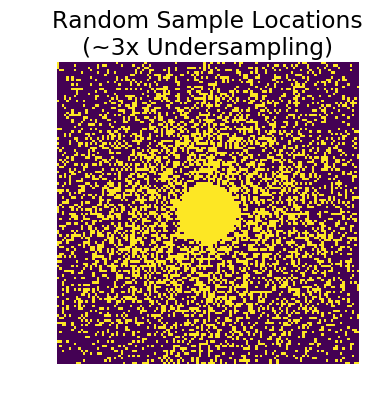

In [67]:
phantom = np.load("/Users/ash/Data/Simulated/shepp_logan_128.npy")[::-1]

mask = np.zeros(phantom.shape, dtype=np.int16)
im_dims = mask.shape
R = 3
n = 0

# gaussian random sampling
vardens_factor = 3
while np.prod(im_dims) / (n + 1) > R:
    y, x = np.array(im_dims) // 2
    x += int(np.random.randn(1) * im_dims[1]/vardens_factor)
    y += int(np.random.randn(1) * im_dims[0]/vardens_factor)
    
    if any((x < 0, y < 0, x >= im_dims[1], y >= im_dims[0])):
        continue
    
    if mask[x, y] == 0:
        mask[x, y] = 1
        n += 1
        # print(np.prod(im_dims) / (n+1))

# center samples
C = 20
Y, X = np.meshgrid(np.linspace(-0.5, 0.5, im_dims[0]), np.linspace(-0.5, 0.5, im_dims[1]))
center_samples = X**2 + Y**2 < (C/2/100)**2
mask += center_samples

print(im_dims, np.prod(im_dims), n, np.prod(im_dims) / n)
fig = plt.figure(figsize=(4,4))
im = plt.imshow(mask > 0, interpolation='none')
plt.title("Random Sample Locations\n(~3x Undersampling)")
plt.axis('off')
plt.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/random_sampling_2d.png", bbox_inches='tight', transparent=True)

In [39]:
b = np.fft.fftshift(np.fft.fft2(phantom*100))[mask > 0]

# add some noise
noise_factor = 1
b += noise_factor * (np.random.randn(*b.shape) + 1j * np.random.randn(*b.shape))

# zero-filling recon
b_ = np.zeros(im_dims, b.dtype)
b_[mask > 0] = b

B = np.fft.ifft2(np.fft.fftshift(b_))
# plt.imshow(np.abs(B))
# plt.colorbar()

In [41]:
hist, x, k = tv_recon_2d(b, mask, 0.1, 1.0, 1.6)
print(k)
x = np.reshape(x, mask.shape)
print(x.shape)

CPU times: user 3min 15s, sys: 2.38 s, total: 3min 17s
Wall time: 49.7 s
1999
(128, 128)


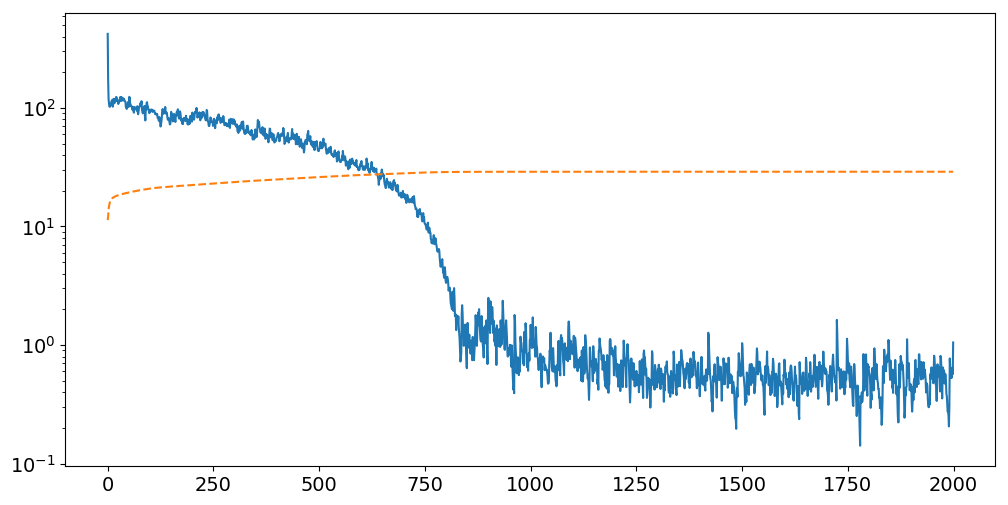

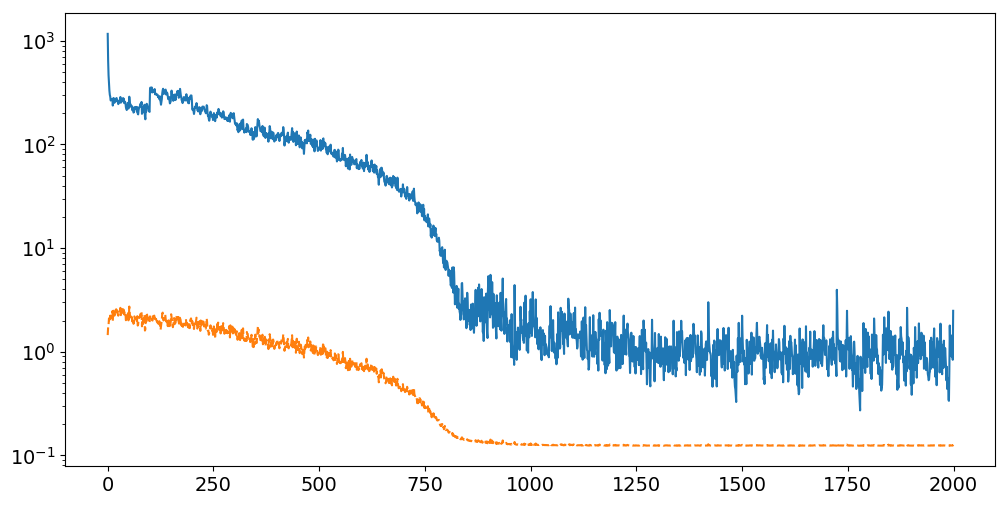

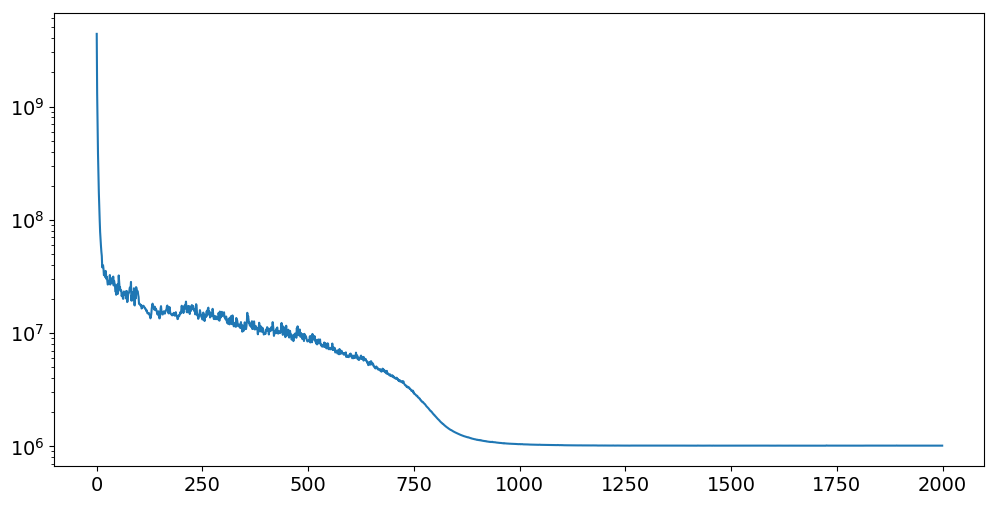

In [42]:
plt.semilogy(hist['r_norm'])
plt.semilogy(hist['eps_prim'], '--')
plt.figure()
plt.semilogy(hist['s_norm'])
plt.semilogy(hist['eps_dual'], '--')
plt.figure()
plt.semilogy(hist['objval'])

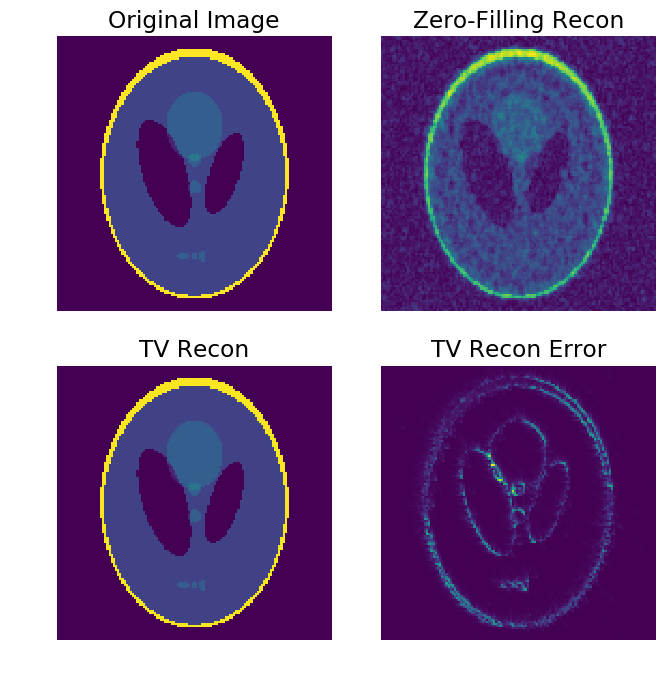

In [60]:
fig, axs = plt.subplots(2, 2, gridspec_kw={'wspace':0.1, 'hspace':0.2}, figsize=(8,8))
axs[0,0].imshow(np.abs(phantom))
axs[0,0].axis('off')
axs[0,0].set_title('Original Image')
axs[0,1].imshow(np.abs(B))
axs[0,1].axis('off')
axs[0,1].set_title('Zero-Filling Recon')
axs[1,0].imshow(np.abs(x))
axs[1,0].axis('off')
axs[1,0].set_title('TV Recon')
axs[1,1].imshow(np.abs(phantom*100 - x))
axs[1,1].axis('off')
axs[1,1].set_title('TV Recon Error')
fig.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/TV_recon_2d.png", bbox_inches='tight', transparent=True)

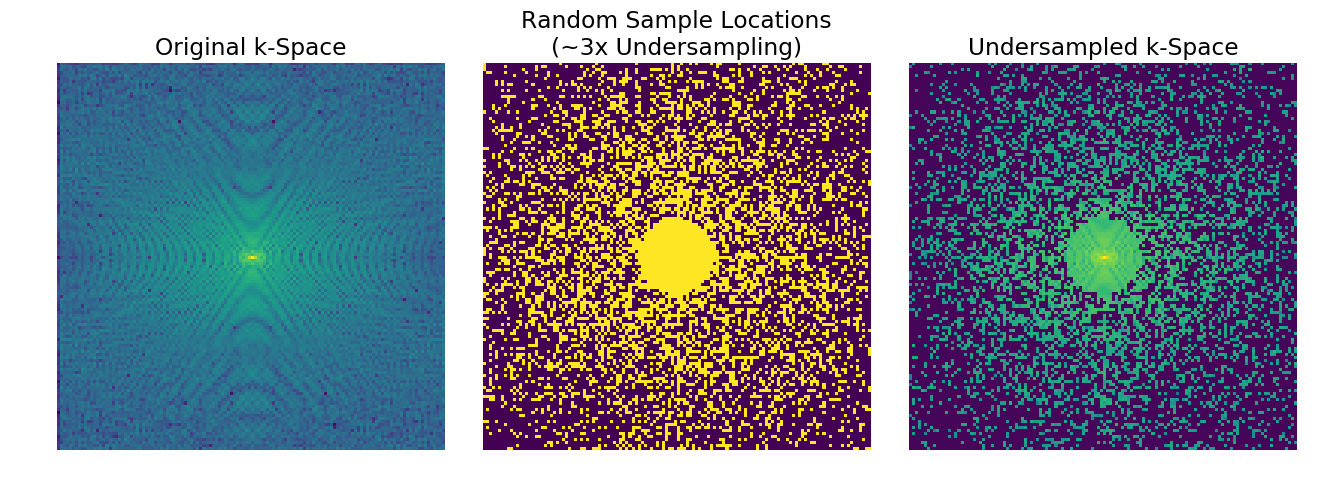

In [73]:

fig, axs = plt.subplots(1, 3, gridspec_kw={'wspace':0.1, 'hspace':0.2}, figsize=(16, 48))
axs[0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(phantom)))**0.1)
axs[0].axis('off')
axs[0].set_title("Original k-Space")
axs[1].imshow(mask > 0, interpolation='none')
axs[1].set_title("Random Sample Locations\n(~3x Undersampling)")
axs[1].axis('off')
axs[2].imshow(np.abs(np.fft.fftshift(np.fft.fft2(B)))**0.1)
axs[2].axis('off')
axs[2].set_title("Undersampled k-Space")
# axs[2].imshow(np.abs(np.fft.fftshift(np.fft.fft2(x)))**0.1)
# axs[2].axis('off')
plt.savefig("/Users/ash/Src/Not Work/aganders3.github.io/content/images/random_sampling_2d.png", bbox_inches='tight', transparent=True)

In [45]:
L1, (h1, v1, d1) = x_wt = pywt.dwt2(x, 'bior1.3')
print(x_wt[0].shape)

W = np.vstack((np.hstack((L1, h1)), np.hstack((v1, d1))))

plt.figure()
plt.imshow(np.abs(W)**0.2)

W = shrinkage(W, 1e-5 * np.max(np.abs(W)))
plt.figure()
plt.imshow(np.abs(W)**0.2)

x_wt = (W[0:66, 0:66], (W[0:66, 66:], W[66:, 0:66], W[66:, 66:]))
print(W.shape)

x_wt_recon = pywt.idwt2(x_wt, 'bior1.3')
print(x_wt_recon.shape)
plt.figure()
plt.imshow(np.abs(x_wt_recon))

NameError: name 'pywt' is not defined